# Sobre clusterização

1) https://medium.com/turing-talks/clustering-conceitos-básicos-principais-algoritmos-e-aplicação-ace572a062a9

2) https://blog.somostera.com/data-science/clusterização-de-dados

3) https://www.sciencedirect.com/science/article/pii/S0167865509002323

In [19]:
import pandas as pd
import category_encoders as ce
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
from sklearn.cluster import KMeans
from kmodes.kmodes import KModes

# Pré-processamento

Pré-processamento. Pode envolver:

1) Remoção de outliers: outliers são observações que se desviam significativamente das outras observações no conjunto de dados (seja por ser um valor muito maior ou menor que os demais) e podem distorcer os resultados da clusterização, puxando o centro de um cluster em sua direção ou criando clusters adicionais desnecessários;

2) Normalização de variáveis: a normalização (ou padronização) das variáveis é essencial, especialmente quando as variáveis estão em diferentes escalas ou unidades;

3) Codificação de categorias: para métodos de clusterização que operam em espaço métrico/númerico, como o K-Means, é necessário converter variáveis categóricas em formatos numéricos através de técnicas como codificação One-Hot ou Binary Encoding;

4) Tratamento de valores nulos: valores nulos podem distorcer a análise de clusterização se não forem adequadamente tratados. Estratégias comuns para lidar com valores nulos incluem imputação, onde valores nulos são substituídos por um valor estimado com base em outras observações (média, mediana ou um valor predito por um modelo), e exclusão, onde linhas ou colunas com valores nulos são removidas;

5) Redução de Dimensionalidade: em conjuntos de dados com alta dimensionalidade (muitas colunas), técnicas de redução de dimensionalidade, como PCA (Análise de Componentes Principais) ou t-SNE, podem ser aplicadas para simplificar os dados sem perder informações essenciais. Isso pode melhorar a eficiência computacional e a qualidade dos clusters, facilitando a identificação de estruturas nos dados;


In [4]:
def FiltraTabela(df, nullValuesPercentAcceptable, uniqueValuesCountAcceptable): 
    # Define um novo dataset com as colunas que possuem um número de valores nulos e occorrências únicas aceitáveis para a codificação,
    # diminuido assim a dimensionalidade
    selectedColumns = []

    # Padronização de valores ausentes. Define os valores em ausentes como "NULO"
    df = df.applymap(lambda x: "NULO" if pd.isnull(x) else x)

    # Para cada coluna do dataset
    for column in df:
        # Cálculo da porcentagem de valores nulos
        nullValuesPercent = (df[column].value_counts().get('NULO', 0) * 100) / len(df)

        # Cálculo do número de ocorrências únicas
        uniqueValuesCount = df[column].nunique()

        # Prints para verificação
        print(f'Coluna: {column}')
        print(f'Porcentagem de Valores Nulos: {nullValuesPercent:.2f}%')
        print(f'Número de Valores Únicos: {uniqueValuesCount}')

        # Condição para compôr o novo dataset
        if nullValuesPercent < nullValuesPercentAcceptable and uniqueValuesCount < uniqueValuesCountAcceptable:
            selectedColumns.append(column)
            print("Inserido\n")
        else:
            print("Não Inserido\n")

    # Cria uma cópia com as colunas definidas anteriormente.
    dfFiltered = df[selectedColumns].copy()

    # Define todas as colunas do dataset como string
    dfFiltered = dfFiltered.astype(str)

    return dfFiltered

def RemoveLinhasComNulos(df):
    # Remove as linhas com valores nulos
    df.dropna(inplace=True)

    # Define todas as colunas do dataset como string
    df = df.astype(str)

    return df



In [5]:
# Leitura do arquivo
nomeDoArquivo = "2014 a 2018-1"
data = pd.read_excel(nomeDoArquivo + ".xlsx")
backup = data.copy()

# Print dos nomes das colunas
data.columns

Index(['Data de cadastro', 'Tipo de violência', 'Violência familiar',
       'Denunciante', 'Filhos vítima', 'Dependência Financeira da Vítima',
       'Sexo da vítima', 'Raça\Cor da vítima', 'Faixa etária da vítima',
       'Grau de instrução da vítima', 'Frequência', 'Coabitação contexto',
       'Tempo de violência contexto', 'Risco contexto',
       'Relação vítima-suspeito', 'Sexo do suspeito', 'Raça\Cor do suspeito',
       'Faixa etária do suspeito', 'Grau de instrução do suspeito',
       'Drogas Álcool Suspeito', 'Comportamento efeito agressor',
       'Filhos violência', 'Violações', 'UF', 'Município', 'Residência'],
      dtype='object')

In [ ]:
# Visualização dos valores nulos com um heatmap
plt.figure(figsize=(20, 10)) 
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.show()

numeroDeLinhasComNulo = data.isnull().any(axis=1).sum()
numeroDeLinhasSemNulo = data.notnull().all(axis=1).sum()
totalDeLinhas = len(data)
print(f"Linhas sem valores nulos: {numeroDeLinhasSemNulo}/{totalDeLinhas} ({numeroDeLinhasSemNulo/totalDeLinhas:.2%})")

# Escolha do Número de Clusters e Algoritmos de Inicialização 

A determinação do número adequado de clusters é fundamental para a preparação de modelos, principalmente para aqueles que utilizam métodos de clusterização que exigem a definição de uma quantidade préviamente, como o K-Modes e K-Means. 

O número de clusters pode, em alguns casos, ser facilmente determinado a partir do contexto de onde foram tirados os dados. Para dados de vendas de uma loja, por exemplo, o número de clusters pode ser referente ao número de produtos que a loja vende, de maneira que cada cluster representa o perfil do cliente que o consome. 

Se não, métodos como o Elbow Method, o Silhouette Score ou o Davies-Bouldin Index podem ajudar a estimar um número ótimo de clusters baseando-se na coesão interna dos clusters e na separação entre eles.

Aqui será usado o Elbow Method para encontrar um K (número de clusters) ótimo para nosso data set, com diferentes algoritmos de escolha para os valores iniciais de referência (modes) de cada cluster.

Todas as execuções serão feitas 5 vezes (n_init = 5) para garantir que não hajam tendências na geração de números aleatórios.

# Clusterização com K-Modes

1) https://pypi.org/project/kmodes/ 

2) https://harikabonthu96.medium.com/kmodes-clustering-2286a9bfdcfb

3) https://awari.com.br/aprenda-a-utilizar-o-k-modes-com-python-para-analise-de-dados/?utm_source=blog&utm_campaign=projeto+blog&utm_medium=Aprenda%20a%20Utilizar%20o%20K-Modes%20com%20Python%20para%20Análise%20de%20Dados

4) https://link.springer.com/article/10.1007/s00357-001-0004-3

In [ ]:
dataFiltered = RemoveLinhasComNulos(data)
# dataFiltered = FiltraTabela(data, 5, 10)

# Definição de com quantos clusters será testado.
numbersOfClustersKModes = range(1,10)

# Vetores para armazenar os "custos" (medida quantitativa de quão bem os clusters foram formados em termos de homogeneidade interna) para o K-Modes
costRandom = []
costCao = []
costHuang = []

In [ ]:
# Escolha aleatória dos modes (init = "random").
for clustersNumber in list(numbersOfClustersKModes):
    kmode = KModes(n_clusters=clustersNumber, init = "random", n_init = 5, verbose=1, n_jobs = -1)
    kmode.fit_predict(dataFiltered)
    costRandom.append(kmode.cost_)

In [ ]:
# Modes escolhidos com base no algoritmo de Cao (init = "cao").
for clustersNumber in list(numbersOfClustersKModes):
    kmode = KModes(n_clusters=clustersNumber, init = "cao", n_init = 5, verbose=1, n_jobs = -1)
    kmode.fit_predict(dataFiltered)
    costCao.append(kmode.cost_)

In [ ]:
# Modes escolhidos com base no algoritmo de Huang (init = "huang").
for clustersNumber in list(numbersOfClustersKModes):
    kmode = KModes(n_clusters=clustersNumber, init = "huang", n_init = 5, verbose=1, n_jobs = -1)
    kmode.fit_predict(dataFiltered)
    costHuang.append(kmode.cost_)

In [ ]:
costsKModes = pd.DataFrame({
    "Random" : costRandom,
    "Cao" : costCao,
    "Huang" : costHuang,
    "Número de Clusters" : numbersOfClustersKModes
})

# Visualização dos custos
#fig = px.line(
#    costsKModes, 
#    x = "Número de Clusters", 
#    y = ["Random", "Cao", "Huang"], 
#    title = (
#        f"Método do Cotovelo para o KModes com até {len(numbersOfClustersKModes)} clusters<br>"
#        f"(dataset: {nomeDoArquivo}, "
#        f"porcentagem de valores nulos aceito: {nullValuesPercentAcceptable}%, "
#        f"quantia de valores únicos por coluna aceito: {uniqueValuesCountAcceptable})"
#    )
#)

# Visualização dos custos
fig = px.line(
    costsKModes, 
    x = "Número de Clusters", 
    y = ["Random", "Cao", "Huang"], 
    title = (
        f"Método do Cotovelo para o KModes com até {len(numbersOfClustersKModes)} clusters<br>"
        f"(dataset: {nomeDoArquivo}, removidas todas as linhas com valores nulos)"
    )
)

fig.update_layout(
    xaxis_title="Número de Clusters",
    yaxis_title="Custo",
    legend_title="Método de Inicialização"
)

fig.show()

# Clusterização com K-Means

## Teste 2

Teste de clusterização sobre colunas especificas de perfil de vítima e suspeito, para as duas codificações. Colunas usadas:

 'Sexo da vítima',
 'Sexo do suspeito', 
 'Raça\Cor da vítima', 
 'Raça\Cor do suspeito',
 'Faixa etária da vítima', 
 'Faixa etária do suspeito',
 'Grau de instrução da vítima', 
 'Grau de instrução do suspeito'

### Teste 2.1

**Codificação**: Binária

In [ ]:
# Seleciona as colunas que serão utilizadas
dataSelectedTest2_1 = data[['Sexo da vítima',
                            'Sexo do suspeito',
                            'Raça\\Cor da vítima',
                            'Raça\\Cor do suspeito',
                            'Faixa etária da vítima',
                            'Faixa etária do suspeito',
                            'Grau de instrução da vítima',
                            'Grau de instrução do suspeito']].copy()

# Visualização dos valores nulos com um heatmap
plt.figure(figsize=(20, 10)) 
sns.heatmap(dataSelectedTest2_1.isnull(), cbar=False, cmap='viridis')
plt.show()

numeroDeLinhasComNulo = dataSelectedTest2_1.isnull().any(axis=1).sum()
numeroDeLinhasSemNulo = dataSelectedTest2_1.notnull().all(axis=1).sum()
totalDeLinhas = len(dataSelectedTest2_1)
print(f"Linhas sem valores nulos: {numeroDeLinhasSemNulo}/{totalDeLinhas} ({numeroDeLinhasSemNulo/totalDeLinhas:.2%})")

# Remove as linhas com valores nulos
dataSelectedTest2_1 = RemoveLinhasComNulos(dataSelectedTest2_1)

# Aplica a codificação Binária
codificador = ce.BinaryEncoder(cols=dataSelectedTest2_1.columns)
dataSelectedEncodedTest2_1 = codificador.fit_transform(dataSelectedTest2_1) 

# Definição de com quantos clusters será testado.
numbersOfClustersKMeansTest2_1 = range(1, 15)

# Vetores para armazenar os "custos" (medida quantitativa de quão bem os clusters foram formados em termos de homogeneidade interna) para o K-Means
inertiaRandomTest2_1 = []
inertiaKMeansTest2_1 = []

In [8]:
# Calculando a inertia para a inicialização 'random'
for clustersNumber in numbersOfClustersKMeansTest2_1:
    kmeans_random = KMeans(n_clusters=clustersNumber, init='random', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
    kmeans_random.fit(dataSelectedEncodedTest2_1)
    inertiaRandomTest2_1.append(kmeans_random.inertia_)

In [9]:
# Calculando a inertia para a inicialização 'k-means++'
for clustersNumber in numbersOfClustersKMeansTest2_1:
    kmeans_kmeans = KMeans(n_clusters=clustersNumber, init='k-means++', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
    kmeans_kmeans.fit(dataSelectedEncodedTest2_1)
    inertiaKMeansTest2_1.append(kmeans_kmeans.inertia_)

In [ ]:
inertiasKMeansTest2_1 = pd.DataFrame({
    "Random" : inertiaRandomTest2_1,
    "K-Means++" : inertiaKMeansTest2_1,
    "Número de Clusters" : numbersOfClustersKMeansTest2_1
})

# Visualização dos custos
fig2_1 = px.line(
    inertiasKMeansTest2_1, 
    x = "Número de Clusters", 
    y = ["Random", "K-Means++"], 
    title = (
        f"Teste 2.1: Método do Cotovelo para o KMeans com até {len(numbersOfClustersKMeansTest2_1)} clusters. Dataset: {nomeDoArquivo}. Codificação: binária.<br>"
        f"Linhas com nulo removidas. Colunas: Sexo, Raça\\Cor, Faixa Etária e Grau de Instrução (vítima e suspeito)"
    )
)

fig2_1.update_layout(
    xaxis_title="Número de Clusters",
    yaxis_title="Inércia",
    legend_title="Método de Inicialização"
)

fig2_1.show()

### Teste 2.2

**Codificação**: One-Hot

In [ ]:
# Seleciona as colunas que serão utilizadas
dataSelectedTest2_2 = data[['Sexo da vítima',
                     'Sexo do suspeito',
                     'Raça\\Cor da vítima',
                     'Raça\\Cor do suspeito',
                     'Faixa etária da vítima',
                     'Faixa etária do suspeito',
                     'Grau de instrução da vítima',
                     'Grau de instrução do suspeito']].copy()

# Visualização dos valores nulos com um heatmap
plt.figure(figsize=(20, 10)) 
sns.heatmap(dataSelectedTest2_2.isnull(), cbar=False, cmap='viridis')
plt.show()

numeroDeLinhasComNulo = dataSelectedTest2_2.isnull().any(axis=1).sum()
numeroDeLinhasSemNulo = dataSelectedTest2_2.notnull().all(axis=1).sum()
totalDeLinhas = len(dataSelectedTest2_2)
print(f"Linhas sem valores nulos: {numeroDeLinhasSemNulo}/{totalDeLinhas} ({numeroDeLinhasSemNulo/totalDeLinhas:.2%})")

# Remove as linhas com valores nulos
dataSelectedTest2_2 = RemoveLinhasComNulos(dataSelectedTest2_2)

# Aplica a codificação One-Hot
dataSelectedEncodedTest2_2 = pd.get_dummies(dataSelectedTest2_2)

# Definição de com quantos clusters será testado.
numbersOfClustersKMeansTest2_2 = range(1, 15)

# Vetores para armazenar os "custos" (medida quantitativa de quão bem os clusters foram formados em termos de homogeneidade interna) para o K-Means
inertiaRandomTest2_2 = []
inertiaKMeansTest2_2 = []

In [14]:
# Calculando a inertia para a inicialização 'random'
for clustersNumber in numbersOfClustersKMeansTest2_2:
    kmeans_random = KMeans(n_clusters=clustersNumber, init='random', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
    kmeans_random.fit(dataSelectedEncodedTest2_2)
    inertiaRandomTest2_2.append(kmeans_random.inertia_)

In [15]:
# Calculando a inertia para a inicialização 'k-means++'
for clustersNumber in numbersOfClustersKMeansTest2_2:
    kmeans_kmeans = KMeans(n_clusters=clustersNumber, init='k-means++', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
    kmeans_kmeans.fit(dataSelectedEncodedTest2_2)
    inertiaKMeansTest2_2.append(kmeans_kmeans.inertia_)

In [ ]:
inertiasKMeansTest2_2 = pd.DataFrame({
    "Random" : inertiaRandomTest2_2,
    "K-Means++" : inertiaKMeansTest2_2,
    "Número de Clusters" : numbersOfClustersKMeansTest2_2
})

# Visualização dos custos
fig2_2 = px.line(
    inertiasKMeansTest2_2, 
    x = "Número de Clusters", 
    y = ["Random", "K-Means++"], 
    title = (
        f"Teste 2.2: Método do Cotovelo para o KMeans com até {len(numbersOfClustersKMeansTest2_2)} clusters. Dataset: {nomeDoArquivo}. Codificação: One-Hot.<br> "
        f"Linhas com nulo removidas, colunas: Sexo, Raça\\Cor, Faixa Etária e Grau de Instrução (vítima e suspeito)"
    )
)

fig2_2.update_layout(
    xaxis_title="Número de Clusters",
    yaxis_title="Inércia",
    legend_title="Método de Inicialização"
)

fig2_2.show()

## Teste 3

Teste de clusterização sobre colunas especificas de perfil apenas da vítima para as duas codificações. Colunas usadas:

 'Sexo da vítima', 
 'Raça\Cor da vítima',
 'Faixa etária da vítima', 
 'Grau de instrução da vítima', 


### Teste 3.1

**Codificação:** Binária

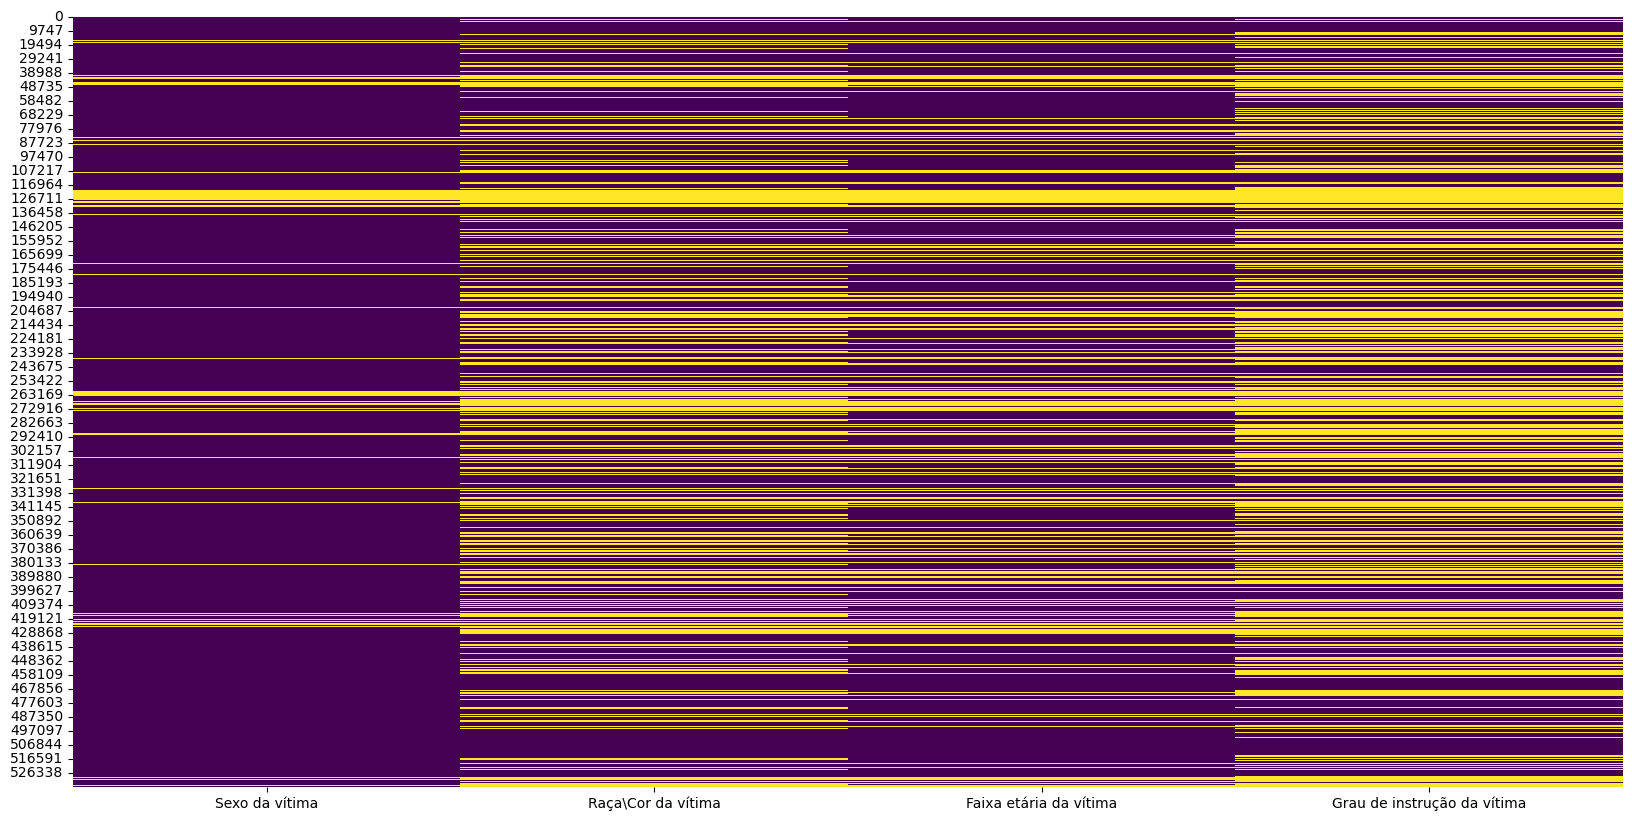

Linhas sem valores nulos: 287737/536041 (53.68%)


In [6]:
# Seleciona as colunas que serão utilizadas
dataSelectedTest3_1 = data[['Sexo da vítima',
                            'Raça\\Cor da vítima',
                            'Faixa etária da vítima',
                            'Grau de instrução da vítima',]].copy()

# Visualização dos valores nulos com um heatmap
plt.figure(figsize=(20, 10)) 
sns.heatmap(dataSelectedTest3_1.isnull(), cbar=False, cmap='viridis')
plt.show()

numeroDeLinhasComNulo = dataSelectedTest3_1.isnull().any(axis=1).sum()
numeroDeLinhasSemNulo = dataSelectedTest3_1.notnull().all(axis=1).sum()
totalDeLinhas = len(dataSelectedTest3_1)
print(f"Linhas sem valores nulos: {numeroDeLinhasSemNulo}/{totalDeLinhas} ({numeroDeLinhasSemNulo/totalDeLinhas:.2%})")

# Remove as linhas com valores nulos
dataSelectedTest3_1 = RemoveLinhasComNulos(dataSelectedTest3_1)

# Aplica a codificação Binária
codificador = ce.BinaryEncoder(cols=dataSelectedTest3_1.columns)
dataSelectedEncodedTest3_1 = codificador.fit_transform(dataSelectedTest3_1) 

# Definição de com quantos clusters será testado.
numbersOfClustersKMeansTest3_1 = range(1, 15)

# Vetores para armazenar os "custos" (medida quantitativa de quão bem os clusters foram formados em termos de homogeneidade interna) para o K-Means
inertiaRandomTest3_1 = []
inertiaKMeansTest3_1 = []

In [7]:
# Calculando a inertia para a inicialização 'random'
for clustersNumber in numbersOfClustersKMeansTest3_1:
    kmeans_random = KMeans(n_clusters=clustersNumber, init='random', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
    kmeans_random.fit(dataSelectedEncodedTest3_1)
    inertiaRandomTest3_1.append(kmeans_random.inertia_)

In [8]:
# Calculando a inertia para a inicialização 'k-means++'
for clustersNumber in numbersOfClustersKMeansTest3_1:
    kmeans_kmeans = KMeans(n_clusters=clustersNumber, init='k-means++', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
    kmeans_kmeans.fit(dataSelectedEncodedTest3_1)
    inertiaKMeansTest3_1.append(kmeans_kmeans.inertia_)

In [9]:
inertiasKMeansTest3_1 = pd.DataFrame({
    "Random" : inertiaRandomTest3_1,
    "K-Means++" : inertiaKMeansTest3_1,
    "Número de Clusters" : numbersOfClustersKMeansTest3_1
})

# Visualização dos custos
fig3_1 = px.line(
    inertiasKMeansTest3_1, 
    x = "Número de Clusters", 
    y = ["Random", "K-Means++"], 
    title = (
        f"Teste 3.1: Método do Cotovelo para o KMeans com até {len(numbersOfClustersKMeansTest3_1)} clusters. Dataset: {nomeDoArquivo}. Codificação: binária.  <br>"
        f"Linhas com nulo removidas. Colunas: Sexo, Raça\\Cor, Faixa Etária e Grau de Instrução (apenas vítima)"
    )
)

fig3_1.update_layout(
    xaxis_title="Número de Clusters",
    yaxis_title="Inércia",
    legend_title="Método de Inicialização",
)

fig3_1.show()

In [10]:
# Aplica a clusterização com 4 clusters
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init=10, max_iter=300)
kmeans.fit(dataSelectedEncodedTest3_1)

# Adiciona os labels dos clusters ao dataset original
dataSelectedTest3_1['Cluster'] = kmeans.labels_

In [ ]:
# Criação de um gráfico 3D para visualização dos clusters
#fig = px.scatter_3d(dataSelectedTest3_1,
#                    x='Faixa etária da vítima',
#                    y='Raça\\Cor da vítima',
#                    z='Grau de instrução da vítima',
#                    color='Cluster',
#                    title='Visualização 3D dos Clusters (Faixa Etária, Grau de Instrução e Raça\\Cor da Vítima)',
#                    labels={'Cluster': 'Cluster'})
#
#fig.show()

In [20]:
# Inicializando o app Dash
app = dash.Dash(__name__)

# Função para criar gráficos
def create_bar_chart(data):
    faixaEtariaCluster = data.groupby(['Faixa etária da vítima', 'Cluster']).size().reset_index(name='Count')
    return px.bar(faixaEtariaCluster, 
                  x='Faixa etária da vítima', 
                  y='Count', 
                  color='Cluster', 
                  barmode='group', 
                  title='Distribuição da Faixa Etária da Vítima por Cluster')

def create_scatter_plot(data):
    return px.scatter(data, 
                      x='Faixa etária da vítima', 
                      y='Grau de instrução da vítima', 
                      color='Cluster', 
                      title='Relação entre Faixa Etária e Grau de Instrução por Cluster',
                      labels={'Faixa etária da vítima': 'Faixa Etária', 'Grau de instrução da vítima': 'Grau de Instrução'})

def create_heatmap(data):
    heatmap_data = pd.crosstab([data['Faixa etária da vítima'], data['Raça\\Cor da vítima']], data['Cluster'], normalize='index')
    return px.imshow(heatmap_data, 
                     title='Distribuição de Faixa Etária e Raça/Cor da Vítima por Cluster',
                     labels={'x': 'Cluster', 'y': 'Faixa etária e Raça/Cor da Vítima'},
                     color_continuous_scale='Viridis')

# Layout do dashboard
app.layout = html.Div([
    html.H1("Dashboard de Análise de Clusters"),

    # Primeiro gráfico - Gráfico de Barras
    dcc.Graph(id='bar-chart', figure=create_bar_chart(dataSelectedTest3_1)),

    # Segundo gráfico - Gráfico de Dispersão
    dcc.Graph(id='scatter-plot', figure=create_scatter_plot(dataSelectedTest3_1)),

    # Terceiro gráfico - Heatmap
    dcc.Graph(id='heatmap', figure=create_heatmap(dataSelectedTest3_1)),
])

# Executando o app
if __name__ == '__main__':
    app.run_server(debug=True)

### Teste 3.2

**Codificação:** One-Hot

In [ ]:
# Seleciona as colunas que serão utilizadas
dataSelectedTest3_2 = data[['Sexo da vítima',
                            'Raça\\Cor da vítima',
                            'Faixa etária da vítima',
                            'Grau de instrução da vítima',]].copy()

# Visualização dos valores nulos com um heatmap
plt.figure(figsize=(20, 10)) 
sns.heatmap(dataSelectedTest3_2.isnull(), cbar=False, cmap='viridis')
plt.show()

numeroDeLinhasComNulo = dataSelectedTest3_2.isnull().any(axis=1).sum()
numeroDeLinhasSemNulo = dataSelectedTest3_2.notnull().all(axis=1).sum()
totalDeLinhas = len(dataSelectedTest3_2)
print(f"Linhas sem valores nulos: {numeroDeLinhasSemNulo}/{totalDeLinhas} ({numeroDeLinhasSemNulo/totalDeLinhas:.2%})")

# Remove as linhas com valores nulos
dataSelectedTest3_2 = RemoveLinhasComNulos(dataSelectedTest3_2)

# Aplica a codificação One-Hot
dataSelectedEncodedTest3_2 = pd.get_dummies(dataSelectedTest3_2)

# Definição de com quantos clusters será testado.
numbersOfClustersKMeansTest3_2 = range(1, 15)

# Vetores para armazenar os "custos" (medida quantitativa de quão bem os clusters foram formados em termos de homogeneidade interna) para o K-Means
inertiaRandomTest3_2 = []
inertiaKMeansTest3_2 = []

In [6]:
# Calculando a inertia para a inicialização 'random'
for clustersNumber in numbersOfClustersKMeansTest3_2:
    kmeans_random = KMeans(n_clusters=clustersNumber, init='random', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
    kmeans_random.fit(dataSelectedEncodedTest3_2)
    inertiaRandomTest3_2.append(kmeans_random.inertia_)

In [7]:
# Calculando a inertia para a inicialização 'k-means++'
for clustersNumber in numbersOfClustersKMeansTest3_2:
    kmeans_kmeans = KMeans(n_clusters=clustersNumber, init='k-means++', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
    kmeans_kmeans.fit(dataSelectedEncodedTest3_2)
    inertiaKMeansTest3_2.append(kmeans_kmeans.inertia_)

In [ ]:
inertiasKMeansTest3_2 = pd.DataFrame({
    "Random" : inertiaRandomTest3_2,
    "K-Means++" : inertiaKMeansTest3_2,
    "Número de Clusters" : numbersOfClustersKMeansTest3_2
})

# Visualização dos custos
fig3_2 = px.line(
    inertiasKMeansTest3_2, 
    x = "Número de Clusters", 
    y = ["Random", "K-Means++"], 
    title = (
        f"Teste 3.2: Método do Cotovelo para o KMeans com até {len(numbersOfClustersKMeansTest3_2)} clusters. Dataset: {nomeDoArquivo}. Codificação: One-Hot.  <br>"
        f"Linhas com nulo removidas. Colunas: Sexo, Raça\\Cor, Faixa Etária e Grau de Instrução (apenas vítima)"
    )
)

fig3_2.update_layout(
    xaxis_title="Número de Clusters",
    yaxis_title="Inércia",
    legend_title="Método de Inicialização",
)

fig3_2.show()

## Teste 4

Teste de clusterização sobre colunas especificas de perfil do suspeito, para as duas codificações. Colunas usadas:

 'Sexo do suspeito',
 'Raça\Cor do suspeito', 
 'Faixa etária do suspeito', 
 'Grau de instrução do suspeito'

### Teste 4.1

**Codificação:** Binária

In [ ]:
# Seleciona as colunas que serão utilizadas
dataSelectedTest4_1 = data[['Sexo do suspeito',
                            'Raça\\Cor do suspeito',
                            'Faixa etária do suspeito',
                            'Grau de instrução do suspeito',]].copy()

# Visualização dos valores nulos com um heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(dataSelectedTest4_1.isnull(), cbar=False, cmap='viridis')
plt.show()

numeroDeLinhasComNulo = dataSelectedTest4_1.isnull().any(axis=1).sum()
numeroDeLinhasSemNulo = dataSelectedTest4_1.notnull().all(axis=1).sum()
totalDeLinhas = len(dataSelectedTest4_1)
print(f"Linhas sem valores nulos: {numeroDeLinhasSemNulo}/{totalDeLinhas} ({numeroDeLinhasSemNulo/totalDeLinhas:.2%})")

# Remove as linhas com valores nulos
dataSelectedTest4_1 = RemoveLinhasComNulos(dataSelectedTest4_1)

# Aplica a codificação Binária
codificador = ce.BinaryEncoder(cols=dataSelectedTest4_1.columns)
dataSelectedEncodedTest4_1 = codificador.fit_transform(dataSelectedTest4_1) 

# Definição de com quantos clusters será testado.
numbersOfClustersKMeansTest4_1 = range(1, 15)

# Vetores para armazenar os "custos" (medida quantitativa de quão bem os clusters foram formados em termos de homogeneidade interna) para o K-Means
inertiaRandomTest4_1 = []
inertiaKMeansTest4_1 = []

In [10]:
# Calculando a inertia para a inicialização 'random'
for clustersNumber in numbersOfClustersKMeansTest4_1:
    kmeans_random = KMeans(n_clusters=clustersNumber, init='random', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
    kmeans_random.fit(dataSelectedEncodedTest4_1)
    inertiaRandomTest4_1.append(kmeans_random.inertia_)


In [11]:
# Calculando a inertia para a inicialização 'k-means++'
for clustersNumber in numbersOfClustersKMeansTest4_1:
    kmeans_kmeans = KMeans(n_clusters=clustersNumber, init='k-means++', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
    kmeans_kmeans.fit(dataSelectedEncodedTest4_1)
    inertiaKMeansTest4_1.append(kmeans_kmeans.inertia_)

In [ ]:
inertiasKMeansTest4_1 = pd.DataFrame({
    "Random" : inertiaRandomTest4_1,
    "K-Means++" : inertiaKMeansTest4_1,
    "Número de Clusters" : numbersOfClustersKMeansTest4_1
})

# Visualização dos custos
fig4_1 = px.line(
    inertiasKMeansTest4_1, 
    x = "Número de Clusters", 
    y = ["Random", "K-Means++"], 
    title = (
        f"Teste 4.1: Método do Cotovelo para o KMeans com até {len(numbersOfClustersKMeansTest4_1)} clusters. Dataset: {nomeDoArquivo}. Codificação: binária.  <br>"
        f"Linhas com nulo removidas. Colunas: Sexo, Raça\\Cor, Faixa Etária e Grau de Instrução (apenas suspeito)"
    )
)

fig4_1.update_layout(
    xaxis_title="Número de Clusters",
    yaxis_title="Inércia",
    legend_title="Método de Inicialização",
)

fig4_1.show()

### Teste 4.2

**Codificação:** One-Hot

In [ ]:
# Seleciona as colunas que serão utilizadas
dataSelectedTest4_2 = data[['Sexo do suspeito',
                            'Raça\\Cor do suspeito',
                            'Faixa etária do suspeito',
                            'Grau de instrução do suspeito',]].copy()

# Visualização dos valores nulos com um heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(dataSelectedTest4_2.isnull(), cbar=False, cmap='viridis')
plt.show()

numeroDeLinhasComNulo = dataSelectedTest4_2.isnull().any(axis=1).sum()
numeroDeLinhasSemNulo = dataSelectedTest4_2.notnull().all(axis=1).sum()
totalDeLinhas = len(dataSelectedTest4_2)
print(f"Linhas sem valores nulos: {numeroDeLinhasSemNulo}/{totalDeLinhas} ({numeroDeLinhasSemNulo/totalDeLinhas:.2%})")

# Remove as linhas com valores nulos
dataSelectedTest4_2 = RemoveLinhasComNulos(dataSelectedTest4_2)

# Aplica a codificação One-Hot
dataSelectedEncodedTest4_2 = pd.get_dummies(dataSelectedTest4_2)

# Definição de com quantos clusters será testado.
numbersOfClustersKMeansTest4_2 = range(1, 15)

# Vetores para armazenar os "custos" (medida quantitativa de quão bem os clusters foram formados em termos de homogeneidade interna) para o K-Means
inertiaRandomTest4_2 = []
inertiaKMeansTest4_2 = []

In [ ]:
# Calculando a inertia para a inicialização 'random'
for clustersNumber in numbersOfClustersKMeansTest4_2:
    kmeans_random = KMeans(n_clusters=clustersNumber, init='random', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
    kmeans_random.fit(dataSelectedEncodedTest4_2)
    inertiaRandomTest4_2.append(kmeans_random.inertia_)

In [ ]:
# Calculando a inertia para a inicialização 'k-means++'
for clustersNumber in numbersOfClustersKMeansTest4_2:
    kmeans_kmeans = KMeans(n_clusters=clustersNumber, init='k-means++', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
    kmeans_kmeans.fit(dataSelectedEncodedTest4_2)
    inertiaKMeansTest4_2.append(kmeans_kmeans.inertia_)

In [ ]:
inertiasKMeansTest4_2 = pd.DataFrame({
    "Random" : inertiaRandomTest4_2,
    "K-Means++" : inertiaKMeansTest4_2,
    "Número de Clusters" : numbersOfClustersKMeansTest4_2
})

# Visualização dos custos
fig4_2 = px.line(
    inertiasKMeansTest4_2, 
    x = "Número de Clusters", 
    y = ["Random", "K-Means++"], 
    title = (
        f"Teste 4.2: Método do Cotovelo para o KMeans com até {len(numbersOfClustersKMeansTest4_2)} clusters. Dataset: {nomeDoArquivo}. Codificação: One-Hot.  <br>"
        f"Linhas com nulo removidas. Colunas: Sexo, Raça\\Cor, Faixa Etária e Grau de Instrução (apenas suspeito)"
    )
)

fig4_2.update_layout(
    xaxis_title="Número de Clusters",
    yaxis_title="Inércia",
    legend_title="Método de Inicialização",
)

fig4_2.show()